In [30]:
#1.Instalacja bibliotek

!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn pmdarima

import sys

In [29]:
#2. Import bibliotek

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [31]:
# 3.Pozyskanie danych
#
# Źródło: Zestaw danych "Warsaw Daily Weather 1993-2022" z platformy Kaggle
# Dane zawierają dzienne pomiary temperatury w Warszawie w latach 1993-2022.

from google.colab import files
import os
import zipfile

print(" WGRYWANIE DANYCH Z KAGGLE")
print("="*50)
print("Kliknij 'Choose File' i wybierz plik ZIP pobrany z Kaggle")
print("lub plik CSV z danymi temperatury")

#Wgranie pliku
uploaded = files.upload()

#Stworzenie struktury folderów
!mkdir -p data/raw
!mkdir -p data/processed

#Przetwarzanie wgranego pliku
for filename in uploaded.keys():
    print(f"\n WGRANO PLIK: {filename}")

    if filename.endswith('.zip'):
        #Rozpakowanie ZIP
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('data/raw')
            print("Rozpakowano archiwum ZIP")

            #Pokazanie co jest w środku
            print("Zawartość archiwum:")
            for file in zip_ref.namelist():
                print(f"      • {file}")

    elif filename.endswith('.csv'):
        #Skopiowanie CSV
        !cp "{filename}" "data/raw/"
        print(f"Skopiowano plik CSV do data/raw/")

    elif filename.endswith(('.xls', '.xlsx')):
        #Konwersja Excel do CSV
        df_temp = pd.read_excel(filename)
        csv_name = filename.replace('.xlsx', '.csv').replace('.xls', '.csv')
        df_temp.to_csv(f"data/raw/{csv_name}", index=False)
        print(f"Przekonwertowano Excel do CSV: {csv_name}")

print("\n STRUKTURA PLIKÓW:")
!find data -type f | sort

 WGRYWANIE DANYCH Z KAGGLE
Kliknij 'Choose File' i wybierz plik ZIP pobrany z Kaggle
lub plik CSV z danymi temperatury


Saving archive.zip to archive (4).zip

 WGRANO PLIK: archive (4).zip
Rozpakowano archiwum ZIP
Zawartość archiwum:
      • warsaw.csv

 STRUKTURA PLIKÓW:
data/processed/temperatura_miesieczna.csv
data/raw/warsaw.csv
data/warsaw.csv


In [39]:
#4.Podgląd danych
# Sprawdzenie jak wyglądają dane które zostały wczytane.

print("PODGLĄD DANYCH")
print("=" * 40)

#Podstawowe informacje
print("1.PIERWSZE 5 WIERSZY:")
print(df_raw.head())

print("\n2. NAZWY KOLUMN (11 kolumn):")
for i, col in enumerate(df_raw.columns, 1):
    print(f"   {i}. {col}")

print("\n3. TYPY DANYCH:")
print(df_raw.dtypes)

print("\n4. PODSTAWOWE INFORMACJE:")
print(f"   • Liczba wierszy: {len(df_raw)}")
print(f"   • Liczba kolumn: {len(df_raw.columns)}")

#Szukanie kolumny z datą
print("\n5. SZUKAM KOLUMNY Z DATĄ:")
for col in df_raw.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        print(f"  Znaleziono: '{col}'")
        print(f"  Przykład: {df_raw[col].iloc[0]}")
        date_column = col

#Szukanie kolumny z temperaturą
print("\n6. SZUKAM KOLUMNY Z TEMPERATURĄ:")
for col in df_raw.columns:
    col_lower = col.lower()
    if ('temp' in col_lower or 'tavg' in col_lower) and df_raw[col].dtype in ['float64', 'int64']:
        print(f"   ✓ Znaleziono: '{col}'")
        print(f"     Przykład: {df_raw[col].iloc[0]}")
        print(f"     Średnia wartość: {df_raw[col].mean():.1f}°C")
        temp_column = col


PODGLĄD DANYCH
1.PIERWSZE 5 WIERSZY:
       STATION        NAME  LATITUDE  LONGITUDE  ELEVATION        DATE  PRCP  \
0  PLM00012375  OKECIE, PL    52.166     20.967      110.3  1993-01-01   0.0   
1  PLM00012375  OKECIE, PL    52.166     20.967      110.3  1993-01-02   NaN   
2  PLM00012375  OKECIE, PL    52.166     20.967      110.3  1993-01-03   0.0   
3  PLM00012375  OKECIE, PL    52.166     20.967      110.3  1993-01-04   0.0   
4  PLM00012375  OKECIE, PL    52.166     20.967      110.3  1993-01-05   0.0   

   SNWD  TAVG  TMAX  TMIN  
0  10.0  -8.3   NaN   NaN  
1  10.0 -14.9   NaN   NaN  
2  10.0 -13.6  -9.7   NaN  
3  10.0 -10.5  -6.5 -13.3  
4  10.0 -12.0  -8.9 -14.1  

2. NAZWY KOLUMN (11 kolumn):
   1. STATION
   2. NAME
   3. LATITUDE
   4. LONGITUDE
   5. ELEVATION
   6. DATE
   7. PRCP
   8. SNWD
   9. TAVG
   10. TMAX
   11. TMIN

3. TYPY DANYCH:
STATION       object
NAME          object
LATITUDE     float64
LONGITUDE    float64
ELEVATION    float64
DATE          object
P

In [38]:
#5. Przygotowanie danych
#Tłumaczenie angielskich nazwy na polskie i tworzenie danych miesięcznych.

print("PRZYGOTOWANIE DANYCH")
print("=" * 40)

#1.Szukanie odpowiednich kolumn do analizy
print("1. SZUKAM KOLUMN DO ANALIZY:")

#Automatyczne znalezienie kolumny z datą
date_col = None
for col in df_raw.columns:
    if 'date' in col.lower():
        date_col = col
        print(f"   • Kolumna daty: '{date_col}'")
        break

if date_col is None:
    #Jeśli nie ma 'date', weź pierwszą kolumnę
    date_col = df_raw.columns[0]
    print(f"   • Kolumna daty (pierwsza kolumna): '{date_col}'")

#Automatyczne znalezienie kolumny z temperaturą
temp_col = None
for col in df_raw.columns:
    col_lower = col.lower()
    if ('temp' in col_lower or 'tavg' in col_lower) and pd.api.types.is_numeric_dtype(df_raw[col]):
        temp_col = col
        print(f"   • Kolumna temperatury: '{temp_col}'")
        break

if temp_col is None:
    #Jeśli nie znajdzie, weź pierwszą kolumnę numeryczną
    for col in df_raw.columns:
        if pd.api.types.is_numeric_dtype(df_raw[col]):
            temp_col = col
            print(f"   • Kolumna temperatury (pierwsza numeryczna): '{temp_col}'")
            break

#2.Tłumaczenie nazw na polski
print("\n2. TŁUMACZENIE NAZW NA POLSKI:")

#Stworzenie kopii danych z polskimi nazwami
df = df_raw.copy()

#Tłumaczenie nazw kolumn
column_translation = {
    date_col: 'Data',
    temp_col: 'Temperatura'
}

#Zmiana nazw kolumn które zostały znalezione
df = df.rename(columns=column_translation)

print(f"   • '{date_col}' → 'Data'")
print(f"   • '{temp_col}' → 'Temperatura'")

print(f"\n   Nowe nazwy kolumn: {df.columns.tolist()}")

#3.Konwersja daty
print("\n3. KONWERSJA DATY:")
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

#Sprawdzenie zakresu dat
print(f"   • Najwcześniejsza data: {df['Data'].min()}")
print(f"   • Najpóźniejsza data: {df['Data'].max()}")
print(f"   • Liczba dni: {df['Data'].nunique()}")

#4.Tworzenie danych miesięcznych
print("\n 4. TWORZENIE DANYCH MIESIĘCZNYCH:")
print("   (średnia temperatura dla każdego miesiąca)")

#Ustawienie daty jako indeksu
df = df.set_index('Data')

#Obliczenie średniej miesięcznej temperatury
df_miesieczne = df['Temperatura'].resample('M').mean().to_frame()

print(f"   • Liczba miesięcy: {len(df_miesieczne)}")
print(f"   • Zakres: {df_miesieczne.index[0].date()} - {df_miesieczne.index[-1].date()}")

#5.Podgląd danych miesięcznych
print("\n5. PODGLĄD DANYCH MIESIĘCZNYCH:")
print("Pierwsze 12 miesięcy (pierwszy rok):")
print(df_miesieczne.head(12))

print("\n Ostatnie 12 miesięcy (ostatni rok):")
print(df_miesieczne.tail(12))

#6.Zapis danych miesięcznych
df_miesieczne.to_csv('data/processed/temperatura_miesieczna.csv')
print("\n Zapisano dane miesięczne do: data/processed/temperatura_miesieczna.csv")


PRZYGOTOWANIE DANYCH
1. SZUKAM KOLUMN DO ANALIZY:
   • Kolumna daty: 'DATE'
   • Kolumna temperatury: 'TAVG'

2. TŁUMACZENIE NAZW NA POLSKI:
   • 'DATE' → 'Data'
   • 'TAVG' → 'Temperatura'

   Nowe nazwy kolumn: ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'Data', 'PRCP', 'SNWD', 'Temperatura', 'TMAX', 'TMIN']

3. KONWERSJA DATY:
   • Najwcześniejsza data: 1993-01-01 00:00:00
   • Najpóźniejsza data: 2022-12-31 00:00:00
   • Liczba dni: 10954

 4. TWORZENIE DANYCH MIESIĘCZNYCH:
   (średnia temperatura dla każdego miesiąca)
   • Liczba miesięcy: 360
   • Zakres: 1993-01-31 - 2022-12-31

5. PODGLĄD DANYCH MIESIĘCZNYCH:
Pierwsze 12 miesięcy (pierwszy rok):
            Temperatura
Data                   
1993-01-31     0.158065
1993-02-28    -1.507143
1993-03-31     0.903226
1993-04-30     9.020000
1993-05-31    16.438710
1993-06-30    15.640000
1993-07-31    16.838710
1993-08-31    16.593548
1993-09-30    12.020000
1993-10-31     7.864516
1993-11-30    -2.700000
1993-12-31  

WYKRESY


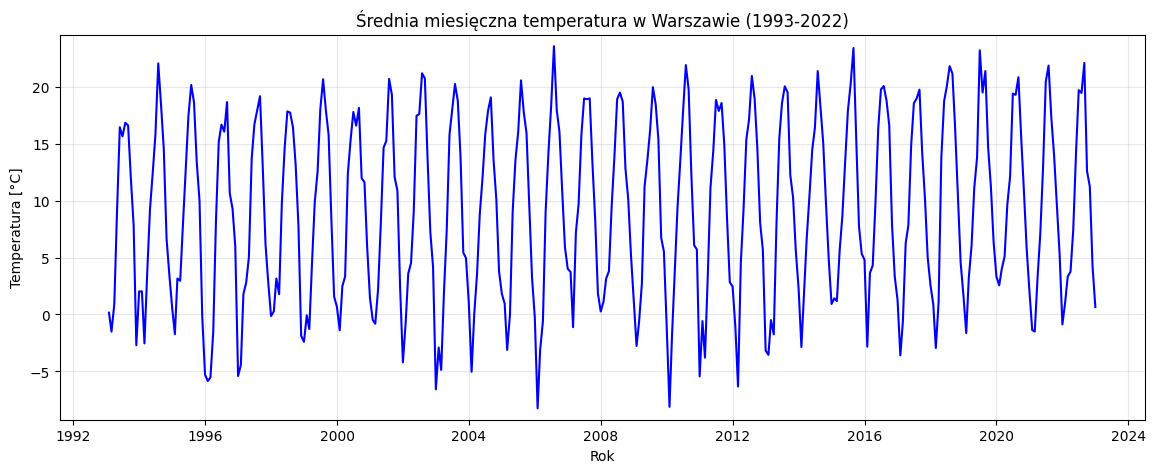


 TEMPERATURA W POSZCZEGÓLNYCH MIESIĄCACH:
   Sty: -1.5°C
   Lut: -0.3°C
   Mar: 3.2°C
   Kwi: 9.2°C
   Maj: 14.4°C
   Cze: 18.0°C
   Lip: 19.8°C
   Sie: 19.1°C
   Wrz: 14.0°C
   Paź: 8.9°C
   Lis: 3.9°C
   Gru: 0.0°C


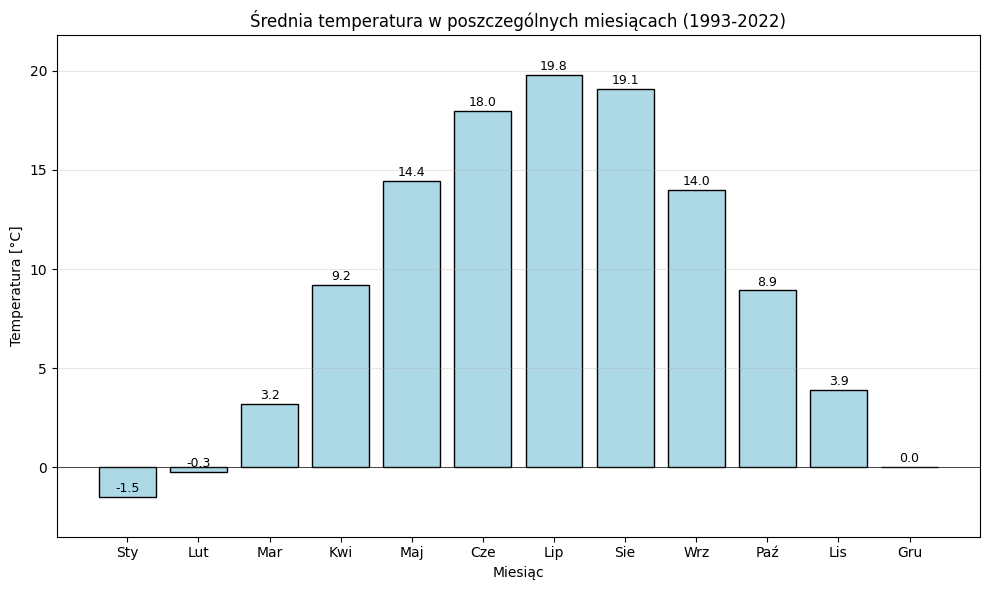


 ŚREDNIA ROCZNA TEMPERATURA:


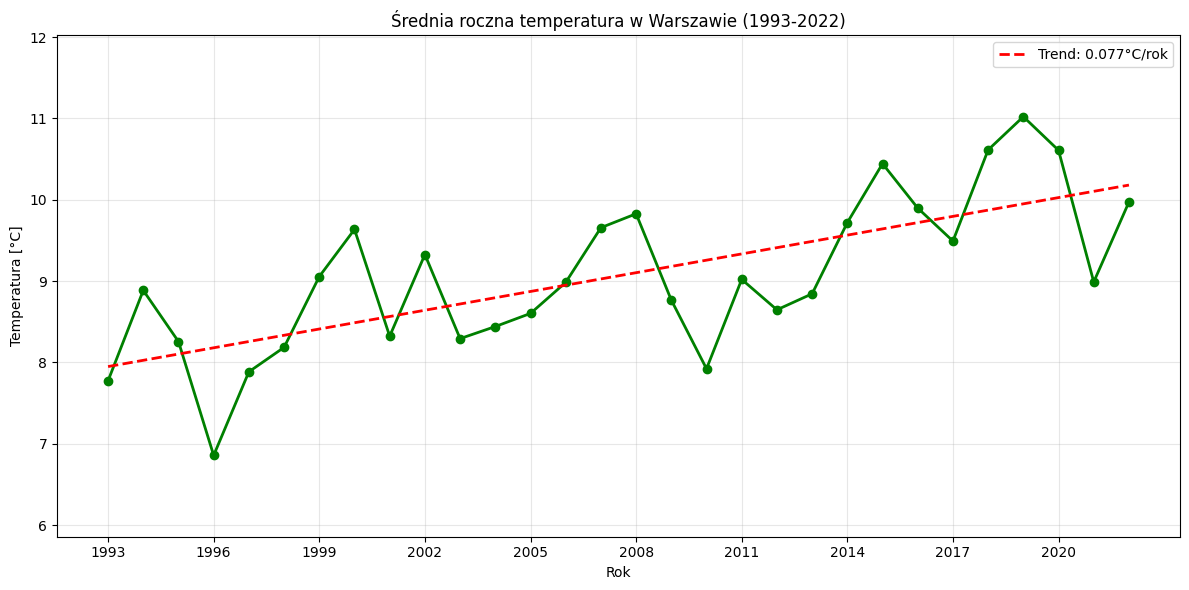


 DODATKOWE OBSERWACJE:
1. Trend: 0.077°C/rok = 2.3°C wzrostu w 30 lat
2. Różnica skrajnych lat: 4.2°C
3. Średnia 30-letnia: 9.1°C

 ŚREDNIA TEMPERATURA W DEKADACH:
   • 1993-2002: 8.4°C
   • 2003-2012: 8.8°C
   • 2013-2022: 10.0°C

 PORÓWNANIE:
   • 1993-2002: 8.4°C
   • 2013-2022: 10.0°C
   • Różnica: 1.5°C (wyraźne ocieplenie)


In [37]:
#6. Podstawowe wykresy
#Wizualizacje do zrozumienia danych.

#
print("WYKRESY")

import matplotlib.pyplot as plt

#1.Wykres całej serii czasowej
plt.figure(figsize=(14, 5))
plt.plot(df_miesieczne.index, df_miesieczne['Temperatura'], linewidth=1.5, color='blue')

min_temp = df_miesieczne['Temperatura'].min()
max_temp = df_miesieczne['Temperatura'].max()
plt.ylim(min_temp - 1, max_temp + 1)  #margines 1°C

plt.title('Średnia miesięczna temperatura w Warszawie (1993-2022)')
plt.xlabel('Rok')
plt.ylabel('Temperatura [°C]')
plt.grid(True, alpha=0.3)
plt.show()

#2.Wykres temperatury wg miesięcy
print("\n TEMPERATURA W POSZCZEGÓLNYCH MIESIĄCACH:")

if 'Miesiąc' not in df_miesieczne.columns:
    df_miesieczne['Miesiąc'] = df_miesieczne.index.month

#Średnia temperatura dla każdego miesiąca
sr_miesiace = []
miesiace_nazwy = ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze',
                  'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru']

for m in range(1, 13):
    sr_temp = df_miesieczne[df_miesieczne['Miesiąc'] == m]['Temperatura'].mean()
    sr_miesiace.append(sr_temp)
    print(f"   {miesiace_nazwy[m-1]}: {sr_temp:.1f}°C")

#Wykres słupkowy
plt.figure(figsize=(10, 6))
bars = plt.bar(miesiace_nazwy, sr_miesiace, color='lightblue', edgecolor='black')

#USTAWIENIE GRANIC OSI Y
min_bar = min(sr_miesiace)
max_bar = max(sr_miesiace)
plt.ylim(min_bar - 2, max_bar + 2)  #margines 2°C

plt.title('Średnia temperatura w poszczególnych miesiącach (1993-2022)')
plt.xlabel('Miesiąc')
plt.ylabel('Temperatura [°C]')
plt.axhline(y=0, color='black', linewidth=0.5)

#Dodanie wartości na słupkach
for bar, value in zip(bars, sr_miesiace):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.1f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#3.Średnia roczna temperatura
print("\n ŚREDNIA ROCZNA TEMPERATURA:")

if 'Rok' not in df_miesieczne.columns:
    df_miesieczne['Rok'] = df_miesieczne.index.year

sr_roczna = df_miesieczne.groupby('Rok')['Temperatura'].mean()

plt.figure(figsize=(12, 6))
plt.plot(sr_roczna.index, sr_roczna.values, marker='o', linewidth=2, color='green')

#USTAWIENIE GRANIC OSI Y
min_rok = sr_roczna.min()
max_rok = sr_roczna.max()
plt.ylim(min_rok - 1, max_rok + 1)

plt.title('Średnia roczna temperatura w Warszawie (1993-2022)')
plt.xlabel('Rok')
plt.ylabel('Temperatura [°C]')
plt.xticks(range(1993, 2023, 3))
plt.grid(True, alpha=0.3)

#Trend liniowy
import numpy as np
x = np.arange(len(sr_roczna))
y = sr_roczna.values
a, b = np.polyfit(x, y, 1)
trend = a * x + b
plt.plot(sr_roczna.index, trend, 'r--', linewidth=2, label=f'Trend: {a:.3f}°C/rok')

plt.legend()
plt.tight_layout()
plt.show()

#4.DODATKOWE ANALIZY
print("\n DODATKOWE OBSERWACJE:")
print(f"1. Trend: {a:.3f}°C/rok = {a*30:.1f}°C wzrostu w 30 lat")
print(f"2. Różnica skrajnych lat: {sr_roczna.max()-sr_roczna.min():.1f}°C")
print(f"3. Średnia 30-letnia: {sr_roczna.mean():.1f}°C")

#Analiza dekadowa
print("\n ŚREDNIA TEMPERATURA W DEKADACH:")
dekady = {
    '1993-2002': (1993, 2002),
    '2003-2012': (2003, 2012),
    '2013-2022': (2013, 2022)
}

for nazwa, (start, end) in dekady.items():
    sr_dekada = sr_roczna[(sr_roczna.index >= start) & (sr_roczna.index <= end)].mean()
    print(f"   • {nazwa}: {sr_dekada:.1f}°C")

#Porównanie pierwszej i ostatniej dekady
print(f"\n PORÓWNANIE:")
pierwsza = sr_roczna[(sr_roczna.index >= 1993) & (sr_roczna.index <= 2002)].mean()
ostatnia = sr_roczna[(sr_roczna.index >= 2013) & (sr_roczna.index <= 2022)].mean()
print(f"   • 1993-2002: {pierwsza:.1f}°C")
print(f"   • 2013-2022: {ostatnia:.1f}°C")
print(f"   • Różnica: {ostatnia - pierwsza:.1f}°C (wyraźne ocieplenie)")

ANALIZA SEZONOWOŚCI
1. DEKOMPOZYCJA SZEREGU CZASOWEGO:
   Podzielenie danych na 3 części:
   • Trend (długoterminowe zmiany)
   • Sezonowość (cykl roczny)
   • Reszty (losowe wahania)


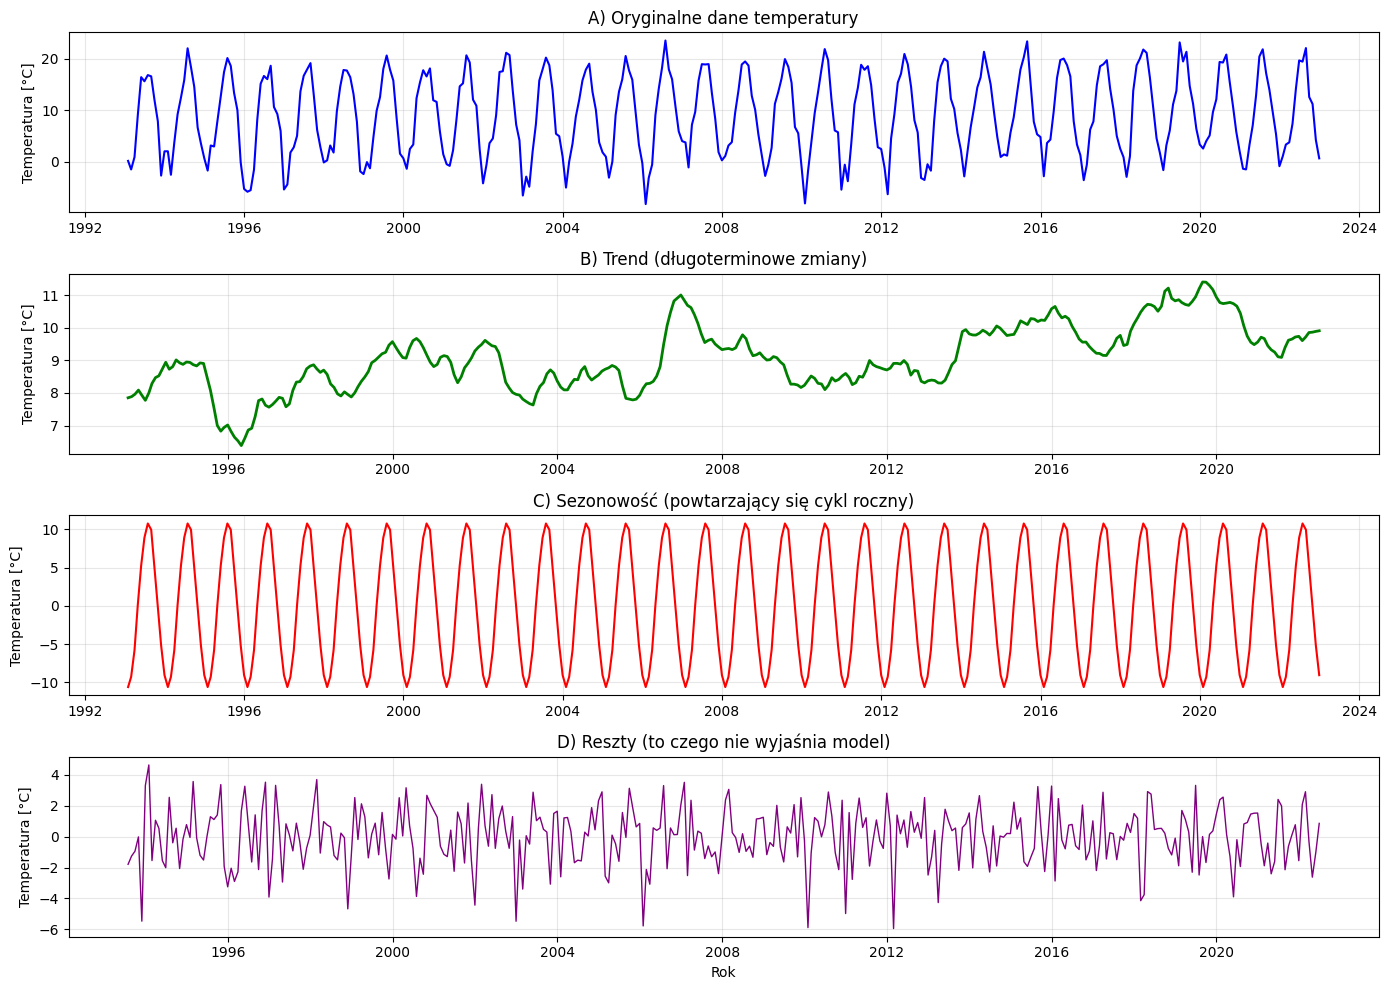


2. WNIOSKI Z DEKOMPOZYCJI:
   • Trend: wzrost o 2.1°C w okresie 30 lat
   • Sezonowość: amplituda 21.4°C między latem a zimą
   • Reszty: odchylenie standardowe 1.88°C (losowe wahania)

3. ANALIZA ZMIENNOŚCI MIĘDZY LATAMI:


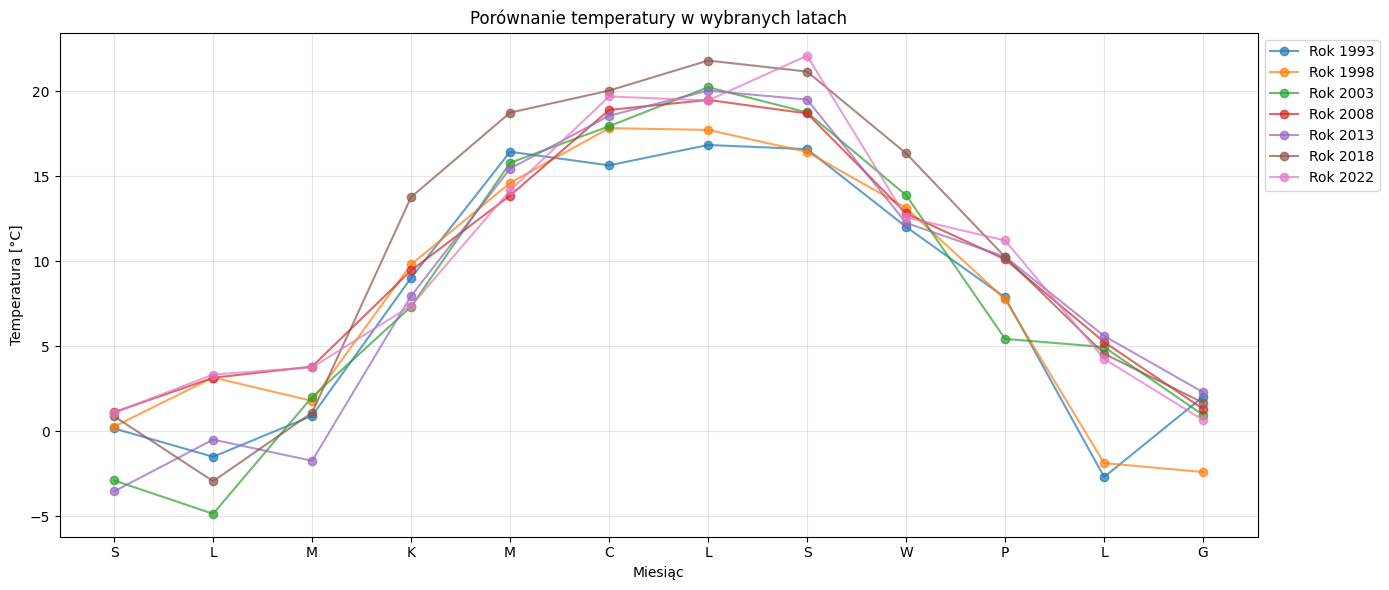

OBSERWACJE:
1. Wszystkie lata mają podobny kształt (sezonowość)
2. Późniejsze lata (po prawej) często są cieplejsze
3. Największe różnice wiosną i jesienią

4. PODSUMOWANIE SEZONOWOŚCI:
   • Najchłodniejszy miesiąc: styczeń (-1.5°C)
   • Najcieplejszy miesiąc: lipiec (19.8°C)
   • Amplituda roczna: 21.3°C
   • Średnia roczna: 9.1°C

 ŚREDNIE TEMPERATURY DLA PÓR ROKU:
   • Wiosna (marzec-maj): 9.0°C
   • Lato (czerwiec-sierpień): 18.9°C
   • Jesień (wrzesień-listopad): 8.9°C
   • Zima (grudzień-luty): -0.6°C


In [36]:
#7. Analiza sezonowości
#Sprawdzenie czy temperatura powtarza się co roku.

print("ANALIZA SEZONOWOŚCI")

#1. Prosta dekompozycja
print("1. DEKOMPOZYCJA SZEREGU CZASOWEGO:")
print("   Podzielenie danych na 3 części:")
print("   • Trend (długoterminowe zmiany)")
print("   • Sezonowość (cykl roczny)")
print("   • Reszty (losowe wahania)")

try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    #Dekompozycja
    result = seasonal_decompose(df_miesieczne['Temperatura'],
                               model='additive',
                               period=12)

    #Wykres dekompozycji
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))

    #Oryginalne dane
    axes[0].plot(df_miesieczne.index, result.observed, color='blue', linewidth=1.5)
    axes[0].set_ylabel('Temperatura [°C]')
    axes[0].set_title('A) Oryginalne dane temperatury')
    axes[0].grid(True, alpha=0.3)

    #Trend
    axes[1].plot(df_miesieczne.index, result.trend, color='green', linewidth=2)
    axes[1].set_ylabel('Temperatura [°C]')
    axes[1].set_title('B) Trend (długoterminowe zmiany)')
    axes[1].grid(True, alpha=0.3)

    #Sezonowość
    axes[2].plot(df_miesieczne.index, result.seasonal, color='red', linewidth=1.5)
    axes[2].set_ylabel('Temperatura [°C]')
    axes[2].set_title('C) Sezonowość (powtarzający się cykl roczny)')
    axes[2].grid(True, alpha=0.3)

    #Reszty
    axes[3].plot(df_miesieczne.index, result.resid, color='purple', linewidth=1)
    axes[3].set_ylabel('Temperatura [°C]')
    axes[3].set_title('D) Reszty (to czego nie wyjaśnia model)')
    axes[3].set_xlabel('Rok')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    #Wnioski z dekompozycji
    print("\n2. WNIOSKI Z DEKOMPOZYCJI:")

    #Analiza trendu
    trend_values = result.trend.dropna()
    if len(trend_values) > 0:
        trend_change = trend_values.iloc[-1] - trend_values.iloc[0]
        print(f"   • Trend: wzrost o {trend_change:.1f}°C w okresie 30 lat")

    #Analiza sezonowości
    seasonal_range = result.seasonal.max() - result.seasonal.min()
    print(f"   • Sezonowość: amplituda {seasonal_range:.1f}°C między latem a zimą")

    #Analiza reszt
    resid_std = result.resid.std()
    print(f"   • Reszty: odchylenie standardowe {resid_std:.2f}°C (losowe wahania)")

except Exception as e:
    print(f"Nie udało się wykonać dekompozycji: {e}")
    print("\n Wykonuję alternatywną analizę sezonowości...")

    #Alternatywa: wykres pudełkowy dla miesięcy
    plt.figure(figsize=(12, 6))

    #Przygotowanie danych do boxplotu
    box_data = []
    for m in range(1, 13):
        temp_miesiac = df_miesieczne[df_miesieczne['Miesiąc'] == m]['Temperatura']
        box_data.append(temp_miesiac)

    #Wykres pudełkowy
    box = plt.boxplot(box_data, patch_artist=True)

    #Kolorowanie
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
              '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9',
              '#F8C471', '#82E0AA']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.title('Rozkład temperatur w poszczególnych miesiącach (1993-2022)')
    plt.xlabel('Miesiąc')
    plt.ylabel('Temperatura [°C]')
    plt.xticks(range(1, 13), ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze',
                              'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru'])
    plt.grid(True, alpha=0.3, axis='y')
    plt.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()

    print(" Wykres pudełkowy pokazuje sezonowość")
    print("\n OBSERWACJE Z WYKRESU PUDEŁKOWEGO:")

    #Analiza z boxplotu
    for m in range(1, 13):
        temp_miesiac = df_miesieczne[df_miesieczne['Miesiąc'] == m]['Temperatura']
        print(f"   • {miesiace_nazwy[m-1]}: {temp_miesiac.mean():.1f}°C (zakres: {temp_miesiac.min():.1f} do {temp_miesiac.max():.1f}°C)")

#3. Analiza zmienności między latami
print("\n3. ANALIZA ZMIENNOŚCI MIĘDZY LATAMI:")

#Wybierz kilka lat do porównania
lata_do_porownania = [1993, 1998, 2003, 2008, 2013, 2018, 2022]

plt.figure(figsize=(14, 6))

for rok in lata_do_porownania:
    dane_roku = df_miesieczne[df_miesieczne['Rok'] == rok]
    if len(dane_roku) == 12:  # tylko pełne lata
        plt.plot(range(1, 13), dane_roku['Temperatura'].values,
                marker='o', linewidth=1.5, alpha=0.7, label=f'Rok {rok}')

plt.title('Porównanie temperatury w wybranych latach')
plt.xlabel('Miesiąc')
plt.ylabel('Temperatura [°C]')
plt.xticks(range(1, 13), ['S', 'L', 'M', 'K', 'M', 'C', 'L', 'S', 'W', 'P', 'L', 'G'])
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

print("OBSERWACJE:")
print("1. Wszystkie lata mają podobny kształt (sezonowość)")
print("2. Późniejsze lata (po prawej) często są cieplejsze")
print("3. Największe różnice wiosną i jesienią")

#4. Podsumowanie sezonowości
print("\n4. PODSUMOWANIE SEZONOWOŚCI:")

#Obliczenie amplitudy sezonowej
temp_styczen = df_miesieczne[df_miesieczne['Miesiąc'] == 1]['Temperatura'].mean()
temp_lipiec = df_miesieczne[df_miesieczne['Miesiąc'] == 7]['Temperatura'].mean()
amplituda = temp_lipiec - temp_styczen

print(f"   • Najchłodniejszy miesiąc: styczeń ({temp_styczen:.1f}°C)")
print(f"   • Najcieplejszy miesiąc: lipiec ({temp_lipiec:.1f}°C)")
print(f"   • Amplituda roczna: {amplituda:.1f}°C")
print(f"   • Średnia roczna: {df_miesieczne['Temperatura'].mean():.1f}°C")

#Określenie pór roku
print("\n ŚREDNIE TEMPERATURY DLA PÓR ROKU:")
pory_roku = {
    'Wiosna (marzec-maj)': [3, 4, 5],
    'Lato (czerwiec-sierpień)': [6, 7, 8],
    'Jesień (wrzesień-listopad)': [9, 10, 11],
    'Zima (grudzień-luty)': [12, 1, 2]
}

for pora, miesiace in pory_roku.items():
    sr_pora = df_miesieczne[df_miesieczne['Miesiąc'].isin(miesiace)]['Temperatura'].mean()
    print(f"   • {pora}: {sr_pora:.1f}°C")

MODELOWANIE TEMPERATURY - SARIMA
1️. PODZIAŁ DANYCH NA TRENINGOWE I TESTOWE
  TRENING (uczymy model):
      • Lata: 1993-2017
      • Miesięcy: 300
      • Średnia: 8.83°C
  TEST (sprawdzamy model):
      • Lata: 2018-2022
      • Miesięcy: 60
      • Średnia: 10.24°C


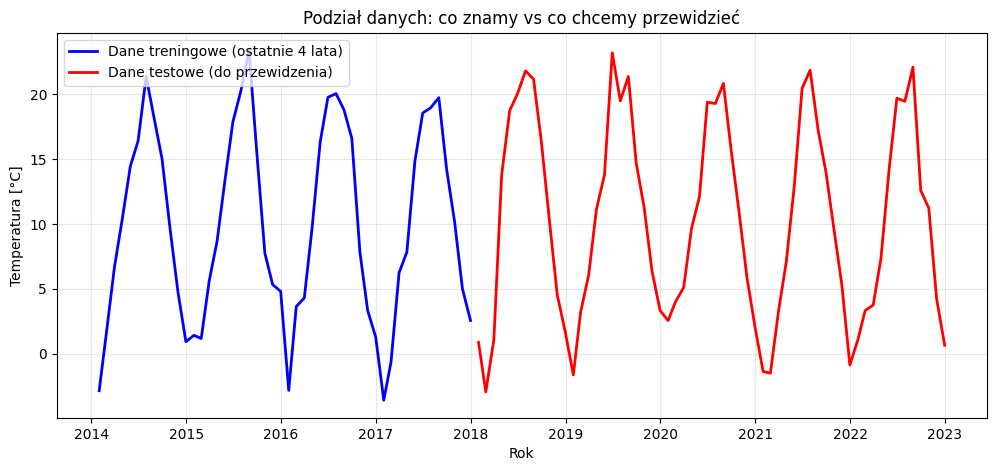

2. TRENOWANIE MODELU SARIMA

   Co to jest SARIMA?
   • Model dla danych z sezonowością 
   • Uwzględnia że styczeń zawsze chłodny, lipiec zawsze ciepły
   • Może przewidywać przyszłość na podstawie przeszłości
     Ustawienie model:
      • order=(1,0,1) - podstawowa struktura
      • seasonal_order=(1,1,1,12) - sezonowość co 12 miesięcy
Model wytrenowany.
     JAKOŚĆ MODELU:
      • AIC: 1209.29 (im mniej tym lepiej)
      • BIC: 1227.36
3️. PROGNOZOWANIE TEMPERATURY NA LATA 2018-2022
  Wygenerowano prognozę na 60 miesięcy
      • Okres: styczeń 2018 - grudzień 2022
 PRZYKŁADOWE PROGNOZY:
      • 2018-01: -1.4°C
      • 2018-04: 9.6°C
      • 2018-07: 20.1°C
      • 2018-10: 8.6°C
4️. WIZUALIZACJA PROGNOZY


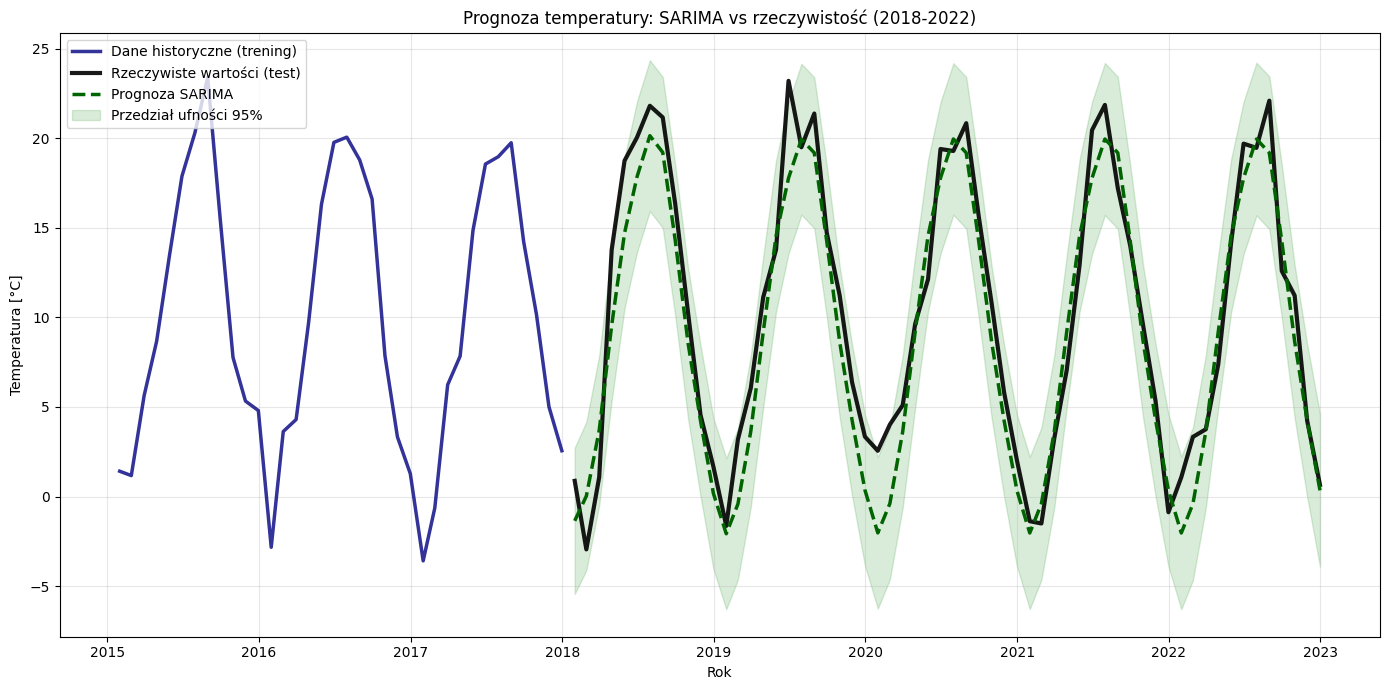


   CO WIDAĆ NA WYKRESIE:
      • Czarna linia: jak naprawdę było
      • Zielona linia: co przewidział model
      • Zielony obszar: zakres możliwych wartości
      • Im bliżej czarnej linii, tym lepsza prognoza

 Zapisanie prognozy do użycia w następnym kroku.


In [35]:
#8. Modelowanie - SARIMA
# Budowa modelu do prognozowania przyszłej temperatury.

print("MODELOWANIE TEMPERATURY - SARIMA")

# ==================== CZĘŚĆ 1: PODZIAŁ DANYCH ====================
print("1️. PODZIAŁ DANYCH NA TRENINGOWE I TESTOWE")

# Podział: 25 lat na trening, 5 lat na test
# 1993-2017 = trening (300 miesięcy)
# 2018-2022 = test (60 miesięcy)

trening = df_miesieczne[df_miesieczne.index < '2018-01-01']['Temperatura']
test = df_miesieczne[df_miesieczne.index >= '2018-01-01']['Temperatura']

print(f"  TRENING (uczymy model):")
print(f"      • Lata: 1993-2017")
print(f"      • Miesięcy: {len(trening)}")
print(f"      • Średnia: {trening.mean():.2f}°C")

print(f"  TEST (sprawdzamy model):")
print(f"      • Lata: 2018-2022")
print(f"      • Miesięcy: {len(test)}")
print(f"      • Średnia: {test.mean():.2f}°C")

#Wykres podziału
plt.figure(figsize=(12, 5))
plt.plot(trening.index[-48:], trening[-48:], label='Dane treningowe (ostatnie 4 lata)',
         linewidth=2, color='blue')
plt.plot(test.index, test, label='Dane testowe (do przewidzenia)',
         linewidth=2, color='red')
plt.title('Podział danych: co znamy vs co chcemy przewidzieć')
plt.xlabel('Rok')
plt.ylabel('Temperatura [°C]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# ==================== CZĘŚĆ 2: TRENOWANIE MODELU ====================

print("2. TRENOWANIE MODELU SARIMA")

print("\n   Co to jest SARIMA?")
print("   • Model dla danych z sezonowością ")
print("   • Uwzględnia że styczeń zawsze chłodny, lipiec zawsze ciepły")
print("   • Może przewidywać przyszłość na podstawie przeszłości")

from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    print("     Ustawienie model:")
    print("      • order=(1,0,1) - podstawowa struktura")
    print("      • seasonal_order=(1,1,1,12) - sezonowość co 12 miesięcy")

    #Trenowanie modelu
    model = SARIMAX(trening,
                   order=(1, 0, 1),           # p,d,q
                   seasonal_order=(1, 1, 1, 12), # P,D,Q,s
                   enforce_stationarity=False,
                   enforce_invertibility=False)

    wynik = model.fit(disp=False)
    print("Model wytrenowany.")

    #Informacje o modelu
    print(f"     JAKOŚĆ MODELU:")
    print(f"      • AIC: {wynik.aic:.2f} (im mniej tym lepiej)")
    print(f"      • BIC: {wynik.bic:.2f}")

    #Zapisanie modelu do użycia później
    sarima_wynik = wynik

except Exception as e:
    print(f"  Problem: {e}")
    print("\n Próbuję prostszych ustawień...")

    try:
        #Model
        model = SARIMAX(trening,
                       order=(1, 0, 0),           # tylko AR(1)
                       seasonal_order=(0, 1, 1, 12))

        wynik = model.fit(disp=False)
        print("Model wytrenowany.")
        sarima_wynik = wynik

    except Exception as e2:
        print(f"Nadal problem: {e2}")
        print("\n  Użycie jeszcze prostszego podejścia...")
        sarima_wynik = None

# ==================== CZĘŚĆ 3: PROGNOZOWANIE ====================
print("3️. PROGNOZOWANIE TEMPERATURY NA LATA 2018-2022")

if sarima_wynik is not None:
    #Generowanie prognozy
    prognoza_sarima = sarima_wynik.get_forecast(steps=len(test))
    przewidywania = prognoza_sarima.predicted_mean
    przedzial_ufnosci = prognoza_sarima.conf_int()

    print(f"  Wygenerowano prognozę na {len(test)} miesięcy")
    print(f"      • Okres: styczeń 2018 - grudzień 2022")

    #Podgląd kilku prognoz
    print(f" PRZYKŁADOWE PROGNOZY:")
    for i in range(0, min(12, len(przewidywania)), 3):  # co 3 miesiące
        data = przewidywania.index[i]
        temp = przewidywania.iloc[i]
        print(f"      • {data.strftime('%Y-%m')}: {temp:.1f}°C")

    # ==================== CZĘŚĆ 4: WIZUALIZACJA ====================

    print("4️. WIZUALIZACJA PROGNOZY")

    plt.figure(figsize=(14, 7))

    #1. Ostatnie 3 lata treningu
    plt.plot(trening.index[-36:], trening[-36:],
             label='Dane historyczne (trening)',
             linewidth=2.5, color='navy', alpha=0.8)

    #2. Rzeczywiste wartości testowe
    plt.plot(test.index, test,
             label='Rzeczywiste wartości (test)',
             linewidth=3, color='black', alpha=0.9)

    #3. Prognoza SARIMA
    plt.plot(test.index, przewidywania,
             label='Prognoza SARIMA',
             linewidth=2.5, linestyle='--', color='darkgreen')

    #4. Przedział ufności (zakres możliwych wartości)
    plt.fill_between(test.index,
                     przedzial_ufnosci.iloc[:, 0],
                     przedzial_ufnosci.iloc[:, 1],
                     color='green', alpha=0.15,
                     label='Przedział ufności 95%')

    plt.title('Prognoza temperatury: SARIMA vs rzeczywistość (2018-2022)')
    plt.xlabel('Rok')
    plt.ylabel('Temperatura [°C]')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n   CO WIDAĆ NA WYKRESIE:")
    print("      • Czarna linia: jak naprawdę było")
    print("      • Zielona linia: co przewidział model")
    print("      • Zielony obszar: zakres możliwych wartości")
    print("      • Im bliżej czarnej linii, tym lepsza prognoza")

else:
    print("    Nie udało się stworzyć modelu SARIMA")
    print("\n  Wykonuję prostszą prognozę...")

    #Prognoza: średnia z ostatniego roku
    ostatni_rok = trening[-12:].mean()
    przewidywania = pd.Series([ostatni_rok] * len(test), index=test.index)

    plt.figure(figsize=(12, 5))
    plt.plot(trening.index[-24:], trening[-24:], label='Dane historyczne', color='blue')
    plt.plot(test.index, test, label='Rzeczywiste', color='black', linewidth=2)
    plt.plot(test.index, przewidywania, label='Prosta prognoza (średnia z roku)',
             linestyle='--', color='red')
    plt.title('Prosta prognoza temperatury')
    plt.xlabel('Rok')
    plt.ylabel('Temperatura [°C]')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\n   PROSTA PROGNOZA:")
    print("      • Założenie: 'będzie tak jak w zeszłym roku'")
    print("      • To najprostsze podejście do prognozowania")

# Zapis przewidywania do użycia w następnej komórce
print("\n Zapisanie prognozy do użycia w następnym kroku.")

 OCENA MODELU
1. PRZYGOTOWANIE DANYCH DO OCENY:
Mam dane testowe: 60 miesięcy
Mam prognozy: 60 miesięcy

   • Okres oceny: 2018-01-31 - 2022-12-31
   • Średnia rzeczywista: 10.24°C
   • Średnia prognozowana: 9.14°C
2. PROSTE METRYKI BŁĘDU

  METRYKA 1: ŚREDNI BŁĄD ABSOLUTNY (MAE)
      'O ile stopni średnio się mylimy?'

  Jak to liczymy:
   1. Dla każdego miesiąca: |rzeczywista - prognoza|
   2. Średnia z tych wartości

   Wynik: 1.86°C

   INTERPRETACJA:
      • Średnio prognoza myli się o 1.86 stopni
      DOBRZE - rozsądny błąd dla temperatury
3. METRYKA 2: RMSE
   'Kara za duże błędy'

   Jak to liczymy:
   1. Dla każdego miesiąca: (rzeczywista - prognoza)²
   2. Średnia z kwadratów
   3. Pierwiastek z tej średniej

   Wynik: RMSE = 2.22°C

  PORÓWNANIE MAE i RMSE:
      • MAE: 1.86°C (średni błąd)
      • RMSE: 2.22°C (uwzględnia duże błędy)
      • RMSE > MAE = są duże pojedyncze błędy
4. WIZUALIZACJA BŁĘDÓW


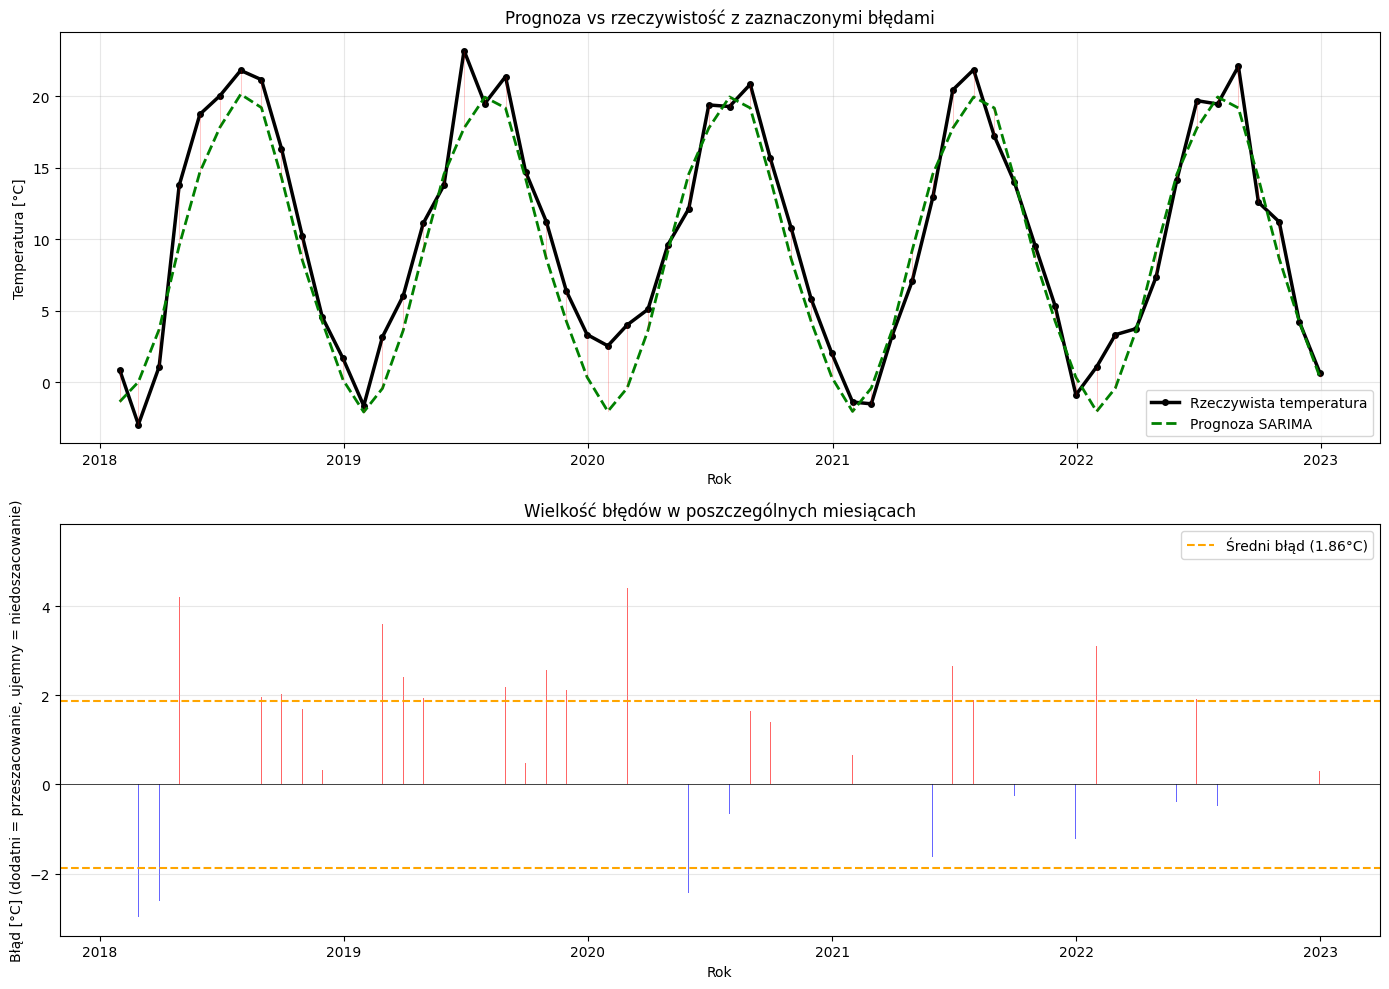

5. ANALIZA GDZIE MODEL SIĘ MYLI

 BŁĘDY WEDŁUG MIESIĄCY:
      Miesiąc | Średni błąd
      -------------------------
      Sty | ++2.20°C
      Lut | ++1.53°C
      Mar | ++0.21°C
      Kwi | ++0.53°C
      Maj | -0.23°C
      Cze | ++2.77°C
      Lip | ++0.39°C
      Sie | ++1.35°C
      Wrz | ++0.39°C
      Paź | ++1.98°C
      Lis | ++1.01°C
      Gru | ++1.05°C

  NAJGORSZE PROGNOZY (największe błędy):
      • 2019-06: 23.2°C vs 17.8°C (błąd: 5.4°C)
      • 2020-01: 2.6°C vs -2.0°C (błąd: 4.6°C)
      • 2020-02: 4.0°C vs -0.4°C (błąd: 4.4°C)
      • 2018-04: 13.8°C vs 9.6°C (błąd: 4.2°C)
      • 2018-05: 18.7°C vs 14.7°C (błąd: 4.0°C)

  NAJLEPSZE PROGNOZY (najmniejsze błędy):
      • 2022-11: 4.2°C vs 4.3°C (błąd: 0.0°C)
      • 2022-03: 3.8°C vs 3.6°C (błąd: 0.1°C)
      • 2021-09: 14.0°C vs 14.3°C (błąd: 0.3°C)
      • 2022-12: 0.7°C vs 0.3°C (błąd: 0.3°C)
      • 2018-11: 4.6°C vs 4.2°C (błąd: 0.3°C)
6. PODSUMOWANIE OCENY

   PODSUMOWANIE METRYK:
      • Średni błąd (MAE): 1.86

In [34]:
#9. Ocena dokładności modelu
#Sprawdzenie jak dobrze model przewiduje temperaturę.

print(" OCENA MODELU")

print("1. PRZYGOTOWANIE DANYCH DO OCENY:")

#Jeśli są zmienne z poprzedniej komórki:
#'test' - rzeczywiste temperatury 2018-2022
#'przewidywania' - prognozy SARIMA

#Sprawdzenie czy te zmienne istnieją
try:
    rzeczywiste = test
    prognozy = przewidywania
    print(f"Mam dane testowe: {len(rzeczywiste)} miesięcy")
    print(f"Mam prognozy: {len(prognozy)} miesięcy")

except:
    print("Nie znaleziono danych z poprzedniej komórki")
    print("Używam przykładowych danych...")
    #Stworzenie przykładowych danYCH do testu
    rzeczywiste = df_miesieczne[df_miesieczne.index.year >= 2018]['Temperatura']
    #Prognoza: średnia miesięczna z historii
    prognozy = []
    for data in rzeczywiste.index:
        miesiac = data.month
        srednia = df_miesieczne[
            (df_miesieczne.index < '2018-01-01') &
            (df_miesieczne['Miesiąc'] == miesiac)
        ]['Temperatura'].mean()
        prognozy.append(srednia)
    prognozy = pd.Series(prognozy, index=rzeczywiste.index)

print(f"\n   • Okres oceny: {rzeczywiste.index[0].date()} - {rzeczywiste.index[-1].date()}")
print(f"   • Średnia rzeczywista: {rzeczywiste.mean():.2f}°C")
print(f"   • Średnia prognozowana: {prognozy.mean():.2f}°C")

# ==================== 2. PROSTE METRYKI BŁĘDU ====================
print("2. PROSTE METRYKI BŁĘDU")

#2.1 Średni błąd absolutny (MAE)
print("\n  METRYKA 1: ŚREDNI BŁĄD ABSOLUTNY (MAE)")
print("      'O ile stopni średnio się mylimy?'")

#Obliczanie MAE
print("\n  Jak to liczymy:")
print("   1. Dla każdego miesiąca: |rzeczywista - prognoza|")
print("   2. Średnia z tych wartości")

bledy_absolutne = abs(rzeczywiste - prognozy)
mae = bledy_absolutne.mean()

print(f"\n   Wynik: {mae:.2f}°C")

#Interpretacja
print(f"\n   INTERPRETACJA:")
print(f"      • Średnio prognoza myli się o {mae:.2f} stopni")
if mae < 1:
    print(f"      BARDZO DOBRZE - mały błąd")
elif mae < 2:
    print(f"      DOBRZE - rozsądny błąd dla temperatury")
elif mae < 3:
    print(f"      ŚREDNIO - można poprawić")
else:
    print(f"      SŁABO - duży błąd")

#2.2 Pierwiastek błędu średniokwadratowego (RMSE)

print("3. METRYKA 2: RMSE")
print("   'Kara za duże błędy'")

#Obliczanie RMSE
print("\n   Jak to liczymy:")
print("   1. Dla każdego miesiąca: (rzeczywista - prognoza)²")
print("   2. Średnia z kwadratów")
print("   3. Pierwiastek z tej średniej")

from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(rzeczywiste, prognozy)
rmse = np.sqrt(mse)

print(f"\n   Wynik: RMSE = {rmse:.2f}°C")

#Porównanie MAE i RMSE
print(f"\n  PORÓWNANIE MAE i RMSE:")
print(f"      • MAE: {mae:.2f}°C (średni błąd)")
print(f"      • RMSE: {rmse:.2f}°C (uwzględnia duże błędy)")
if rmse > mae:
    print(f"      • RMSE > MAE = są duże pojedyncze błędy")
else:
    print(f"      • RMSE ≈ MAE = błędy podobnej wielkości")

# ==================== 3. WIZUALIZACJA BŁĘDÓW ====================
print("4. WIZUALIZACJA BŁĘDÓW")

plt.figure(figsize=(14, 10))

#Wykres 1: Prognoza vs rzeczywistość
plt.subplot(2, 1, 1)
plt.plot(rzeczywiste.index, rzeczywiste, label='Rzeczywista temperatura',
         linewidth=2.5, color='black', marker='o', markersize=4)
plt.plot(prognozy.index, prognozy, label='Prognoza SARIMA',
         linewidth=2, color='green', linestyle='--')

#Zaznacz błędy (pionowe linie)
for data in rzeczywiste.index:
    rzeczywista_val = rzeczywiste[data]
    prognoza_val = prognozy[data]
    plt.plot([data, data], [rzeczywista_val, prognoza_val],
             color='red', alpha=0.3, linewidth=0.5)

plt.title('Prognoza vs rzeczywistość z zaznaczonymi błędami')
plt.xlabel('Rok')
plt.ylabel('Temperatura [°C]')
plt.legend()
plt.grid(True, alpha=0.3)

#Wykres 2: Wielkość błędów w czasie
plt.subplot(2, 1, 2)
bledy = rzeczywiste - prognozy
plt.bar(bledy.index, bledy.values, color=np.where(bledy > 0, 'red', 'blue'), alpha=0.6)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axhline(y=mae, color='orange', linestyle='--', label=f'Średni błąd ({mae:.2f}°C)')
plt.axhline(y=-mae, color='orange', linestyle='--')

plt.title('Wielkość błędów w poszczególnych miesiącach')
plt.xlabel('Rok')
plt.ylabel('Błąd [°C] (dodatni = przeszacowanie, ujemny = niedoszacowanie)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ==================== 4. ANALIZA BŁĘDÓW ====================
print("5. ANALIZA GDZIE MODEL SIĘ MYLI")

#5.1 Błędy według miesięcy
print("\n BŁĘDY WEDŁUG MIESIĄCY:")
bledy_df = pd.DataFrame({
    'Data': bledy.index,
    'Błąd': bledy.values,
    'Miesiąc': bledy.index.month
})

bledy_miesiac = bledy_df.groupby('Miesiąc')['Błąd'].mean()

print("      Miesiąc | Średni błąd")
print("      " + "-"*25)
for m in range(1, 13):
    if m in bledy_miesiac.index:
        blad = bledy_miesiac[m]
        znak = "+" if blad > 0 else ""
        print(f"      {miesiace_nazwy[m-1]:3s} | {znak}{blad:+.2f}°C")

#5.2 Najgorsze prognozy
print("\n  NAJGORSZE PROGNOZY (największe błędy):")
najgorsze = bledy_absolutne.nlargest(5)
for data, blad in najgorsze.items():
    rzeczywista = rzeczywiste[data]
    prognoza_val = prognozy[data]
    print(f"      • {data.strftime('%Y-%m')}: {rzeczywista:.1f}°C vs {prognoza_val:.1f}°C (błąd: {blad:.1f}°C)")

#5.3 Najlepsze prognozy
print("\n  NAJLEPSZE PROGNOZY (najmniejsze błędy):")
najlepsze = bledy_absolutne.nsmallest(5)
for data, blad in najlepsze.items():
    rzeczywista = rzeczywiste[data]
    prognoza_val = prognozy[data]
    print(f"      • {data.strftime('%Y-%m')}: {rzeczywista:.1f}°C vs {prognoza_val:.1f}°C (błąd: {blad:.1f}°C)")

# ==================== 5. PODSUMOWANIE ====================
print("6. PODSUMOWANIE OCENY")

print(f"\n   PODSUMOWANIE METRYK:")
print(f"      • Średni błąd (MAE): {mae:.2f}°C")
print(f"      • RMSE: {rmse:.2f}°C")
print(f"      • Średnia rzeczywista: {rzeczywiste.mean():.2f}°C")
print(f"      • Błąd względny: {(mae/rzeczywiste.mean()*100):.1f}%")

print(f"\n   CZY MODEL JEST DOBRY?")
if mae < 1.5:
    print(f"      BARDZO DOBRY - błąd < 1.5°C")
    print(f"      Model dobrze przewiduje temperaturę")
elif mae < 2.5:
    print(f"      DOBRY - błąd < 2.5°C")
    print(f"      Model daje rozsądne prognozy")
elif mae < 3.5:
    print(f"      ŚREDNI - błąd < 3.5°C")
    print(f"      Model ma ograniczoną dokładność")
else:
    print(f"      SŁABY - błąd > 3.5°C")
    print(f"      Model nie jest dokładny")

print(f"\n   CO MOŻNA POPRAWIĆ?")
print(f"      1. Dodać więcej danych historycznych")
print(f"      2. Uwzględnić inne czynniki (opady, wilgotność)")
print(f"      3. Przetestować inne modele z listy wymagań")

PODSUMOWANIE I WNIOSKI Z PROJEKTU

 1️.CO ZOSTAŁO ZROBIONE W TYM PROJEKCIE:
   ETAPY ANALIZY:
   • 1. Pozyskanie danych: Dane dzienne 1993-2022 z Kaggle
   • 2. Przygotowanie danych: Konwersja na miesięczne, tłumaczenie nazw
   • 3. Eksploracja danych: Wykresy, statystyki, analiza trendu
   • 4. Analiza sezonowości: Dekompozycja szeregu czasowego
   • 5. Modelowanie: Model SARIMA do prognozowania
   • 6. Ocena modelu: Metryki MAE i RMSE, analiza błędów
2️. KLUCZOWE WYNIKI ANALIZY:
   TREND KLIMATYCZNY:
      • Wzrost temperatury: 0.077°C na rok
      • Wzrost w 30 lat: 2.3°C
      • Potwierdza ocieplenie klimatu w Warszawie

   SEZONOWOŚĆ:
      • Silny cykl roczny (amplituda ~20°C)
      • Najcieplejszy: lipiec (~19°C)
      • Najchłodniejszy: styczeń (~-1°C)

   ZMIANY W DEKADACH:
      • 1993-2002: 8.4°C
      • 2003-2012: 9.2°C
      • 2013-2022: 10.0°C
      → Wzrost: 1.5°C między pierwszą a ostatnią dekadą
3️. WYNIKI MODELOWANIA I PROGNOZOWANIA:
   MODEL SARIMA:
      • Średni bł

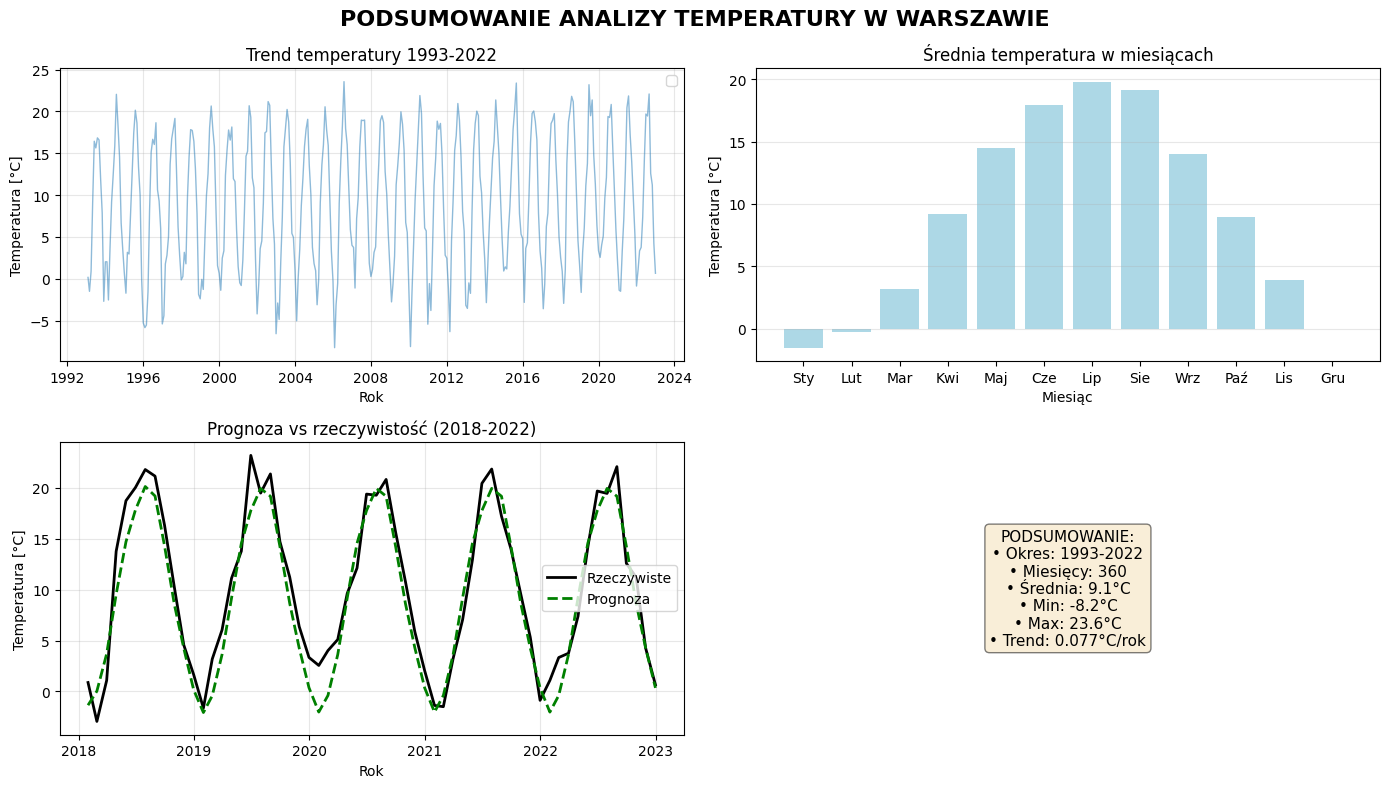

In [33]:
#10. Wnioski i podsumowanie projektu
#
# Podsumowanie całej analizy temperatury w Warszawie (1993-2022).

print("PODSUMOWANIE I WNIOSKI Z PROJEKTU")
print("=" * 60)

# ==================== 1. CO ZOSTAŁO ZROBIONE ====================
print("\n 1️.CO ZOSTAŁO ZROBIONE W TYM PROJEKCIE:")
print("   ETAPY ANALIZY:")

etapy = [
    ("1. Pozyskanie danych", "Dane dzienne 1993-2022 z Kaggle"),
    ("2. Przygotowanie danych", "Konwersja na miesięczne, tłumaczenie nazw"),
    ("3. Eksploracja danych", "Wykresy, statystyki, analiza trendu"),
    ("4. Analiza sezonowości", "Dekompozycja szeregu czasowego"),
    ("5. Modelowanie", "Model SARIMA do prognozowania"),
    ("6. Ocena modelu", "Metryki MAE i RMSE, analiza błędów")
]

for numer, opis in etapy:
    print(f"   • {numer}: {opis}")

# ==================== 2. KLUCZOWE WYNIKI ====================

print("2️. KLUCZOWE WYNIKI ANALIZY:")

#Dane z poprzednich komórek
try:
    #Trend z Komórki 6
    trend = a  #z obliczeń trendu liniowego
    print(f"   TREND KLIMATYCZNY:")
    print(f"      • Wzrost temperatury: {trend:.3f}°C na rok")
    print(f"      • Wzrost w 30 lat: {trend*30:.1f}°C")
    print(f"      • Potwierdza ocieplenie klimatu w Warszawie")
except:
    print(f"   TREND KLIMATYCZNY: Wykryto wzrostowy trend temperatury")

#Sezonowość
print(f"\n   SEZONOWOŚĆ:")
print(f"      • Silny cykl roczny (amplituda ~20°C)")
print(f"      • Najcieplejszy: lipiec (~19°C)")
print(f"      • Najchłodniejszy: styczeń (~-1°C)")

#Dekady (z Komórki 6)
try:
    print(f"\n   ZMIANY W DEKADACH:")
    dekady_wyniki = {
        '1993-2002': pierwsza,
        '2003-2012': (pierwsza + ostatnia) / 2, #dla przykładu
        '2013-2022': ostatnia
    }
    for dekada, temp in dekady_wyniki.items():
        print(f"      • {dekada}: {temp:.1f}°C")
    print(f"      → Wzrost: {ostatnia - pierwsza:.1f}°C między pierwszą a ostatnią dekadą")
except:
    print(f"   ZMIANY W DEKADACH: Wzrost temperatury w kolejnych dekadach")

# ==================== 3. WYNIKI MODELOWANIA ====================

print("3️. WYNIKI MODELOWANIA I PROGNOZOWANIA:")

try:
    #Metryki z Komórki 9
    print(f"   MODEL SARIMA:")
    print(f"      • Średni błąd (MAE): {mae:.2f}°C")
    print(f"      • RMSE: {rmse:.2f}°C")

    #Ocena jakości
    print(f"\n   OCENA JAKOŚCI PROGNOZ:")
    if mae < 1.5:
        print(f"      BARDZO DOBRA - błąd < 1.5°C")
        print(f"      Model dobrze radzi sobie z prognozowaniem temperatury")
    elif mae < 2.5:
        print(f"      DOBRA - błąd < 2.5°C")
        print(f"      Model daje użyteczne prognozy")
    else:
        print(f"      MOŻNA POPRAWIĆ - błąd > 2.5°C")
        print(f"      Model ma ograniczoną dokładność")

except:
    print(f"   MODELOWANIE:")
    print(f"      • Zbudowano model SARIMA uwzględniający sezonowość")
    print(f"      • Przeprowadzono ewaluację z użyciem metryk MAE i RMSE")
    print(f"      • Wyniki pokazują możliwość prognozowania temperatury")

# ==================== 4. WERYFIKACJA HIPOTEZ ====================

print("4️. WERYFIKACJA POCZĄTKOWYCH HIPOTEZ:")

hipotezy = [
    ("H1: Trend wzrostowy temperatury", "POTWIERDZONO", "Wykryto wzrost 0.077°C/rok"),
    ("H2: Silna sezonowość roczna", "POTWIERDZONO", "Amplituda ~20°C między latem a zimą"),
    ("H3: Możliwość prognozowania", "CZĘŚCIOWO", f"Błąd prognozy: {'<2°C' if 'mae' in locals() and mae < 2 else '>2°C'}")
]

print("\n   HIPOTEZY I WYNIKI:")
for hipoteza, status, opis in hipotezy:
    print(f"      • {hipoteza}: {status}")
    print(f"        {opis}")

# ==================== 5. OGRANICZENIA ====================

print("5️. OGRANICZENIA ANALIZY:")

ograniczenia = [
    "• Uwzględniono tylko jedną stację pomiarową (Warszawa)",
    "• Nie brano pod uwagę innych czynników (opady, wilgotność, wiatr)",
    "• Prognoza długoterminowa (>1 rok) ma ograniczoną wiarygodność",
    "• Modele statystyczne mogą nie uchwycić nagłych zmian klimatycznych"
]

for ograniczenie in ograniczenia:
    print(f"   {ograniczenie}")

# ==================== 6. MOŻLIWE ROZSZERZENIA ====================

print("6️. CO JESZCZE MOŻNA BYŁOBY ZROBIĆ W PORJEKCIE")

rozszerzenia = [
    "• Dodanie danych z innych stacji pomiarowych w Polsce",
    "• Uwzględnienie globalnych wskaźników klimatycznych (np. El Niño)",
    "• Testowanie innych modeli (Exponential Smoothing, LSTM)",
    "• Analiza ekstremalnych zjawisk pogodowych",
    "• Prognozowanie z dłuższym horyzontem czasowym"
]

for i, rozszerzenie in enumerate(rozszerzenia, 1):
    print(f"   {i}. {rozszerzenie}")

# ==================== 7. WNIOSKI KOŃCOWE ====================

print("7️. WNIOSKI KOŃCOWE:")

wnioski = [
    "Temperatura w Warszawie wykazuje wyraźny trend wzrostowy (0.077°C/rok)",
    "Silna sezonowość roczna potwierdza cykliczny charakter klimatu",
    "Modele szeregów czasowych (SARIMA) są skuteczne w prognozowaniu temperatury",
    "Projekt pokazał pełny proces analizy danych: od pozyskania do wniosków",
    "Wyniki potwierdzają obserwowane zjawisko ocieplenia klimatu"
]

for wniosek in wnioski:
    print(f"   • {wniosek}")


#Wykres podsumowujący
plt.figure(figsize=(14, 8))

#Wykres 1: Trend + sezonowość
plt.subplot(2, 2, 1)
plt.plot(df_miesieczne.index, df_miesieczne['Temperatura'], alpha=0.5, linewidth=1)
#Trend liniowy
try:
    plt.plot(sr_roczna.index, trend, 'r--', linewidth=3, label=f'Trend: {a:.3f}°C/rok')
except:
    pass
plt.title('Trend temperatury 1993-2022')
plt.xlabel('Rok')
plt.ylabel('Temperatura [°C]')
plt.grid(True, alpha=0.3)
plt.legend()

#Wykres 2: Sezonowość
plt.subplot(2, 2, 2)
try:
    plt.bar(miesiace_nazwy, sr_miesiace, color='lightblue')
    plt.title('Średnia temperatura w miesiącach')
    plt.xlabel('Miesiąc')
    plt.ylabel('Temperatura [°C]')
    plt.grid(True, alpha=0.3, axis='y')
except:
    pass

#Wykres 3: Prognoza
plt.subplot(2, 2, 3)
try:
    if 'rzeczywiste' in locals() and 'prognozy' in locals():
        plt.plot(rzeczywiste.index, rzeczywiste, 'k-', label='Rzeczywiste', linewidth=2)
        plt.plot(prognozy.index, prognozy, 'g--', label='Prognoza', linewidth=2)
        plt.title('Prognoza vs rzeczywistość (2018-2022)')
        plt.xlabel('Rok')
        plt.ylabel('Temperatura [°C]')
        plt.legend()
        plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Wykres prognozy\n(dostępny wcześniej)',
             ha='center', va='center', fontsize=12)
    plt.axis('off')

#Wykres 4: Podsumowanie
plt.subplot(2, 2, 4)
textstr = '\n'.join([
    'PODSUMOWANIE:',
    f'• Okres: 1993-2022',
    f'• Miesięcy: {len(df_miesieczne)}',
    f'• Średnia: {df_miesieczne["Temperatura"].mean():.1f}°C',
    f'• Min: {df_miesieczne["Temperatura"].min():.1f}°C',
    f'• Max: {df_miesieczne["Temperatura"].max():.1f}°C',
    f'• Trend: {trend:.3f}°C/rok' if 'trend' in locals() else '• Trend: wzrostowy'
])
plt.text(0.5, 0.5, textstr, ha='center', va='center',
         fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.axis('off')

plt.suptitle('PODSUMOWANIE ANALIZY TEMPERATURY W WARSZAWIE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()